In [9]:
import pandas as pd
df = pd.read_csv("data/all_data.csv")
df.drop(["relig_pct", "Unnamed: 0", "population_WPP", "population_WRP", "youth_literacy_gpi"],axis=1, inplace=True)
df = df[df["year"] != 2024]
df.to_csv("data/all_but_relig.csv")
df.loc[df["name"] == "Namibia", "alpha_2"] = "NA"
print(df.shape)
df = df.dropna(subset=["GDP"])
print(df.shape)


(19200, 14)
(13985, 14)


C:\Users\tvuontis\AppData\Local\Temp\ipykernel_21852\3573685293.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_frac = df.groupby("name").apply(lambda g: g.isna().mean().mean())


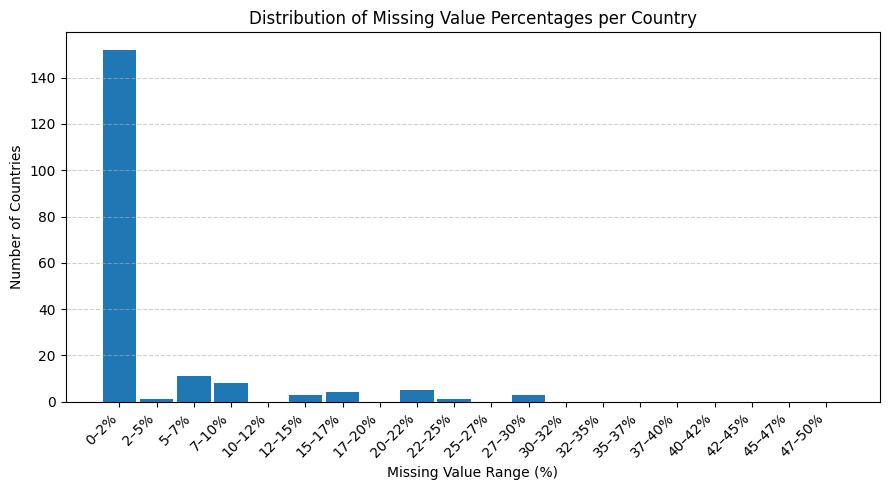

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming you already have missing_frac


# Define bins
bins = np.arange(0, 0.51, 0.025)

# Assign to bins
binned = pd.cut(missing_frac, bins=bins, right=False)

# Count countries per bin
counts = binned.value_counts().sort_index()

# Convert the index to IntervalIndex if needed
intervals = counts.index.categories if hasattr(counts.index, "categories") else counts.index

# Create readable labels
labels = [f"{int(interval.left*100)}–{int(interval.right*100)}%" for interval in intervals]

# Plot
plt.figure(figsize=(9,5))
plt.bar(labels, counts.values, width=0.9)
plt.title("Distribution of Missing Value Percentages per Country")
plt.xlabel("Missing Value Range (%)")
plt.ylabel("Number of Countries")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
x = 0.1  # for example, drop countries with >30% missing values overall
missing_frac = df.groupby("name").apply(lambda g: g.isna().mean().mean())

remove_countries = missing_frac[missing_frac >= x].index
# print(len(remove_countries))

print(df.shape)
df = df[~df["name"].isin(remove_countries)]
df.to_csv("data/all_data_tuomas_0910.csv")
print(df.shape)

(13985, 14)
(9568, 14)


In [12]:
# Count missing HCI per country
missing_hci = df[df["human_capital_index"].isna()]
missing_count = missing_hci["name"].value_counts()

# Count total rows per country
total_count = df["name"].value_counts()

# Combine into one DataFrame
country_missing = (
    pd.DataFrame({
        "missing_hci": missing_count,
        "total_rows": total_count
    })
    .fillna(0)
    .astype(int)
    .sort_values("missing_hci", ascending=False)
)

# Add share of missing
country_missing["missing_share_%"] = (
    100 * country_missing["missing_hci"] / country_missing["total_rows"]
).round(1)

missing_hci_countries  = list(country_missing[country_missing["missing_share_%"] > 0].head(20).index)
missing_hci_countries += ['Bosnia and Herzegovina', 'Haiti']
df = df[~df["name"].isin(missing_hci_countries)]
df.shape

(8594, 14)

In [13]:
def drop_leading_nans(group, col="infant_mortality_rate"):
    # Find the first index where value is not NaN
    first_valid = group[col].first_valid_index()
    # If the whole column is NaN, drop the group entirely
    if first_valid is None:
        return pd.DataFrame(columns=group.columns)
    # Otherwise keep rows from the first valid value onward
    return group.loc[first_valid:]
    
df = (
    df.sort_values(["name", "year"])
      .groupby("name", group_keys=False)
      .apply(drop_leading_nans)
      .reset_index(drop=True)
)
df.shape
df.to_csv("data/all_data_0910.csv")



C:\Users\tvuontis\AppData\Local\Temp\ipykernel_21852\281456486.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(drop_leading_nans)


In [14]:
def drop_trailing_nans(group, col="internet_users_pct"):
    # Find the last index where value is not NaN
    last_valid = group[col].last_valid_index()
    # If everything is NaN, drop the group entirely
    if last_valid is None:
        return pd.DataFrame(columns=group.columns)
    # Keep rows from start up to the last valid value
    return group.loc[:last_valid]

df = (
    df.sort_values(["name", "year"])
      .groupby("name", group_keys=False)
      .apply(drop_trailing_nans)
      .reset_index(drop=True)
)
df.to_csv("data/clean_data.csv")
total_nans = df.isna().sum().sum()
print("Total NaN values:", total_nans)

df.shape

C:\Users\tvuontis\AppData\Local\Temp\ipykernel_21852\3977114810.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(drop_trailing_nans)


Total NaN values: 0


(8438, 14)